aci binary

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7644
[LightGBM] [Info] Number of data points in the train set: 48012, number of used features: 30
[LightGBM] [Info] Start training from score -2.395773
[LightGBM] [Info] Start training from score -2.389392
[LightGBM] [Info] Start training from score -2.382374
[LightGBM] [Info] Start training from score -2.392350
[LightGBM] [Info] Start training from score -2.403116
[LightGBM] [Info] Start training from score -2.407733
[LightGBM] [Info] Start training from score -2.404268
[LightGBM] [Info] Start training from score -2.398062
[LightGBM] [Info] Start training from score -2.400126
[LightGBM] [Info] Start training from score -2.399208
[LightGBM] [Info] Start tra

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


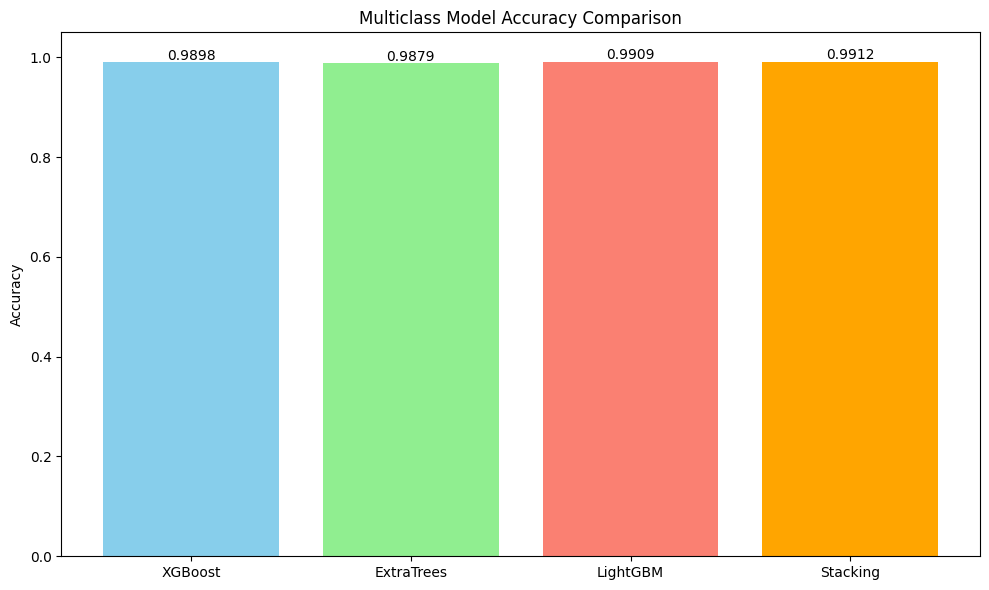

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Load data
df = pd.read_csv("/content/multi_featk_aci.csv")

# Label Encoding for multiclass labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Split features and target
X = df.drop(['Label'], axis=1)
y = df['Label']

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Results dictionary
results = {}

# ----------- XGBoost (Multiclass) -----------
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.2,
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    verbosity=0
)
xgb.fit(X_train, y_train)


results["XGBoost"] = {
    "Accuracy": accuracy_score(y_val, xgb.predict(X_val))
}

# ----------- Extra Trees -----------
et = ExtraTreesClassifier(
    n_estimators=128,
    max_depth=30,
    random_state=42,
    n_jobs=-1
)
et.fit(X_train, y_train)


results["ExtraTrees"] = {
    "Accuracy": accuracy_score(y_val, et.predict(X_val))
}

# ----------- LightGBM (Multiclass) -----------
lgb = LGBMClassifier(
    n_estimators=143,
    max_depth=44,
    learning_rate=0.171,
    objective='multiclass',
    num_class=len(np.unique(y)),
    random_state=42
)
lgb.fit(X_train, y_train)
lgb_preds = lgb.predict(X_val)

results["LightGBM"] = {
    "Accuracy": accuracy_score(y_val, lgb_preds)
}



# ----------- Stacking Ensemble -----------
# Train meta-model on training set predictions
xgb_pred_train = xgb.predict_proba(X_train)
et_pred_train = et.predict_proba(X_train)
lgb_pred_train = lgb.predict_proba(X_train)

meta_X_train = np.hstack((xgb_pred_train, et_pred_train, lgb_pred_train))
meta_y_train = y_train

meta_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
meta_model.fit(meta_X_train, meta_y_train)

# Predict on validation set using base models
xgb_pred_val = xgb.predict_proba(X_val)
et_pred_val = et.predict_proba(X_val)
lgb_pred_val = lgb.predict_proba(X_val)

meta_X_val = np.hstack((xgb_pred_val, et_pred_val, lgb_pred_val))
meta_preds = meta_model.predict(meta_X_val)

stacked_accuracy = accuracy_score(y_val, meta_preds)

results["Stacking"] = {
    "Accuracy": stacked_accuracy
}

# ----------- Plot Accuracy Comparison -----------
models = list(results.keys())
accuracies = [d['Accuracy'] for d in results.values()]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=["skyblue", "lightgreen", "salmon", "orange", "mediumpurple"])
plt.ylim(0, 1.05)
plt.ylabel('Accuracy')
plt.title('Multiclass Model Accuracy Comparison')

for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.005, f"{acc:.4f}", ha='center')

plt.tight_layout()
plt.savefig("ensemble_accuracy_comparison_multiclass_aci.png", dpi=300)
plt.show()
